In [63]:
import cv2 as cv
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

In [64]:
from midas.run import process, load_model
from midas.utils import read_image
# require timm==0.6.12
# or the state dict won't load (why?)
# https://github.com/isl-org/MiDaS/blob/bdc4ed64c095e026dc0a2f17cabb14d58263decb/environment.yaml#L15C7-L15C19


In [65]:
from pathlib import Path

is_use_mlsd_large = True
MIDAS_MODEL_PATH = "dpt_swin2_tiny_256.pt"
MLSD_TINY_MODEL_PATH = "mlsd/mlsd_tiny_512_fp32.pth"
MLSD_LARGE_MODEL_PATH = "mlsd/mlsd_large_512_fp32.pth"
if is_use_mlsd_large:
    MLSD_MODEL_PATH = MLSD_LARGE_MODEL_PATH
else:
    MLSD_MODEL_PATH = MLSD_TINY_MODEL_PATH
VIDEO_PATH = "rotated.avi"
OUTPUT_PATH = "output.avi"
video_path = Path(VIDEO_PATH)
midas_model_path = Path(MIDAS_MODEL_PATH)
mlsd_model_path = Path(MLSD_MODEL_PATH)
output_path = Path(OUTPUT_PATH)
assert video_path.exists(), f"Video file does not exist at {video_path}"
assert midas_model_path.exists(), f"Model file does not exist at {midas_model_path}"
assert mlsd_model_path.exists(), f"Model file does not exist at {mlsd_model_path}"

In [66]:
# device = torch.device("cpu") # use CPU intentionally
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimize=False
side=False
height=None
square=False
grayscale=False
model_type = "dpt_swin2_tiny_256"
model, transform, net_w, net_h = load_model(device, MIDAS_MODEL_PATH, model_type, optimize, height, square)
print("device: {} model_type: {}".format(device, model_type))

Model loaded, number of parameters = 42M
device: cuda model_type: dpt_swin2_tiny_256


In [67]:
cap = cv.VideoCapture(VIDEO_PATH)
fps = cap.get(cv.CAP_PROP_FPS)
w = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
all_frames = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
at_frame = 120
assert at_frame < all_frames
cap.set(cv.CAP_PROP_POS_FRAMES, at_frame)
display("{}x{} @ {} FPS ({}/{})".format(w, h, fps, at_frame, all_frames))
ret, frame = cap.read()
# writer = cv.VideoWriter(OUTPUT_PATH, cv.VideoWriter_fourcc(*'mp4v'), fps, (w, h))
if ret == True:
  if frame.ndim == 2:
      frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  frame = cv2.normalize(frame, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)
assert ret == True
cap.release()

'1280x720 @ 30.0 FPS (120/893)'

    Input resized to 256x256 before entering the encoder


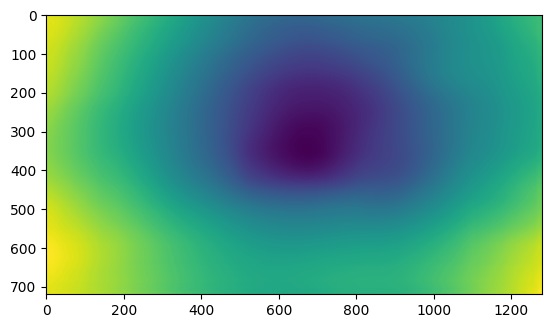

In [68]:
img = frame
img_size = img.shape[1::-1]
resized = transform({"image": img/255})["image"]
uint8_max = np.iinfo(np.uint8).max
with torch.no_grad():
  depth = process(device, model, model_type, resized, (net_w, net_h), img_size, optimize, False)
mask = cv2.normalize(depth, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
plt.imshow(mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


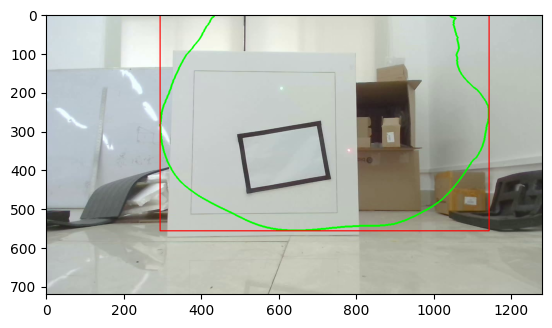

In [69]:
res = img.copy()
u8_mask = cv2.normalize(depth, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
inverted = cv2.bitwise_not(u8_mask)
ret, limited = cv2.threshold(inverted, 0, 255, cv.THRESH_OTSU)
contours, hierarchy = cv2.findContours(limited, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
bbs = []
for contour in contours:
  area = cv2.contourArea(contour)
  cv2.drawContours(res, [contour], 0, (0, 255, 0), 3)
  if area > 100:
    box = cv2.boundingRect(contour)
    x, y, w, h = box
    bbs.append(box)
    cv2.rectangle(res, (x, y), (x+w, y+h), (255, 0, 0), 2)
plt.imshow(res)

In [70]:
def scale_back(after_x, after_y, before_size:tuple[int, int], after_size:tuple[int, int]):
    """
    Scale back the coordinates of the line segment to the original image size.
    :param after_x: The x coordinates of the line segment after scaling.
    :param after_y: The y coordinates of the line segment after scaling.
    :param before_size: The size of the original image. (width, height)
    :param after_size: The size of the image after scaling. (width, height)
    :return: The coordinates of the line segment after scaling back.
    """
    before_x = after_x * before_size[0] / after_size[0]
    before_y = after_y * before_size[1] / after_size[1]
    return before_x, before_y

def scale_line_back(line:tuple[float, float, float, float], before_size:tuple[int, int], after_size:tuple[int, int]):
    """
    Scale back the coordinates of the line segment to the original image size.
    :param line: The coordinates of the line segment after scaling.
    :param before_size: The size of the original image. (width, height)
    :param after_size: The size of the image after scaling. (width, height)
    :return: The coordinates of the line segment after scaling back.
    """
    after_x1, after_y1, after_x2, after_y2 = line
    before_x1, before_y1 = scale_back(after_x1, after_y1, before_size, after_size)
    before_x2, before_y2 = scale_back(after_x2, after_y2, before_size, after_size)
    return before_x1, before_y1, before_x2, before_y2

In [76]:
from mlsd.tiny import MobileV2_MLSD_Tiny
from mlsd.large import MobileV2_MLSD_Large
from mlsd.utils import pred_lines

res_prime = res.copy()
if is_use_mlsd_large:
  mlsd = MobileV2_MLSD_Large().cuda().eval()
else:
  mlsd = MobileV2_MLSD_Tiny().cuda().eval()
MLSD_SIZE = 512
mlsd_size = (MLSD_SIZE, MLSD_SIZE)
u8_img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U).astype(np.uint8)
h, w = u8_img.shape[:2]
display("image size {}x{} -> {}x{}".format(img_size[0], img_size[1], mlsd_size[0], mlsd_size[1]))
resized = cv2.resize(u8_img, (MLSD_SIZE, MLSD_SIZE))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlsd.load_state_dict(torch.load(mlsd_model_path, map_location=device), strict=True)
lines = pred_lines(resized, mlsd, [MLSD_SIZE, MLSD_SIZE], 0.5, 20)
display("found {} lines".format(len(lines)))

if len(lines) == 0:
  display("No lines found")
else:
  for l in lines:
    x1, y1, x2, y2 = scale_line_back(l, (w, h), mlsd_size)
    cv2.line(res_prime, (int(x1), int(y1)), (int(x2), int(y2)), (0,200,200), 1,16)
  plt.imshow(res_prime)

'image size 1280x720 -> 512x512'

RuntimeError: Error(s) in loading state_dict for MobileV2_MLSD_Large:
	Missing key(s) in state_dict: "backbone.features.11.conv.0.0.weight", "backbone.features.11.conv.0.1.weight", "backbone.features.11.conv.0.1.bias", "backbone.features.11.conv.0.1.running_mean", "backbone.features.11.conv.0.1.running_var", "backbone.features.11.conv.1.0.weight", "backbone.features.11.conv.1.1.weight", "backbone.features.11.conv.1.1.bias", "backbone.features.11.conv.1.1.running_mean", "backbone.features.11.conv.1.1.running_var", "backbone.features.11.conv.2.weight", "backbone.features.11.conv.3.weight", "backbone.features.11.conv.3.bias", "backbone.features.11.conv.3.running_mean", "backbone.features.11.conv.3.running_var", "backbone.features.12.conv.0.0.weight", "backbone.features.12.conv.0.1.weight", "backbone.features.12.conv.0.1.bias", "backbone.features.12.conv.0.1.running_mean", "backbone.features.12.conv.0.1.running_var", "backbone.features.12.conv.1.0.weight", "backbone.features.12.conv.1.1.weight", "backbone.features.12.conv.1.1.bias", "backbone.features.12.conv.1.1.running_mean", "backbone.features.12.conv.1.1.running_var", "backbone.features.12.conv.2.weight", "backbone.features.12.conv.3.weight", "backbone.features.12.conv.3.bias", "backbone.features.12.conv.3.running_mean", "backbone.features.12.conv.3.running_var", "backbone.features.13.conv.0.0.weight", "backbone.features.13.conv.0.1.weight", "backbone.features.13.conv.0.1.bias", "backbone.features.13.conv.0.1.running_mean", "backbone.features.13.conv.0.1.running_var", "backbone.features.13.conv.1.0.weight", "backbone.features.13.conv.1.1.weight", "backbone.features.13.conv.1.1.bias", "backbone.features.13.conv.1.1.running_mean", "backbone.features.13.conv.1.1.running_var", "backbone.features.13.conv.2.weight", "backbone.features.13.conv.3.weight", "backbone.features.13.conv.3.bias", "backbone.features.13.conv.3.running_mean", "backbone.features.13.conv.3.running_var", "block17.conv1.0.weight", "block17.conv1.0.bias", "block17.conv1.1.weight", "block17.conv1.1.bias", "block17.conv1.1.running_mean", "block17.conv1.1.running_var", "block17.conv2.0.weight", "block17.conv2.0.bias", "block17.conv2.1.weight", "block17.conv2.1.bias", "block17.conv2.1.running_mean", "block17.conv2.1.running_var", "block18.conv1.0.weight", "block18.conv1.0.bias", "block18.conv1.1.weight", "block18.conv1.1.bias", "block18.conv1.1.running_mean", "block18.conv1.1.running_var", "block18.conv2.0.weight", "block18.conv2.0.bias", "block18.conv2.1.weight", "block18.conv2.1.bias", "block18.conv2.1.running_mean", "block18.conv2.1.running_var", "block19.conv1.0.weight", "block19.conv1.0.bias", "block19.conv1.1.weight", "block19.conv1.1.bias", "block19.conv1.1.running_mean", "block19.conv1.1.running_var", "block19.conv2.0.weight", "block19.conv2.0.bias", "block19.conv2.1.weight", "block19.conv2.1.bias", "block19.conv2.1.running_mean", "block19.conv2.1.running_var", "block20.conv1.0.weight", "block20.conv1.0.bias", "block20.conv1.1.weight", "block20.conv1.1.bias", "block20.conv1.1.running_mean", "block20.conv1.1.running_var", "block20.conv2.0.weight", "block20.conv2.0.bias", "block20.conv2.1.weight", "block20.conv2.1.bias", "block20.conv2.1.running_mean", "block20.conv2.1.running_var", "block21.conv1.0.weight", "block21.conv1.0.bias", "block21.conv1.1.weight", "block21.conv1.1.bias", "block21.conv1.1.running_mean", "block21.conv1.1.running_var", "block21.conv2.0.weight", "block21.conv2.0.bias", "block21.conv2.1.weight", "block21.conv2.1.bias", "block21.conv2.1.running_mean", "block21.conv2.1.running_var", "block22.conv1.0.weight", "block22.conv1.0.bias", "block22.conv1.1.weight", "block22.conv1.1.bias", "block22.conv1.1.running_mean", "block22.conv1.1.running_var", "block22.conv2.0.weight", "block22.conv2.0.bias", "block22.conv2.1.weight", "block22.conv2.1.bias", "block22.conv2.1.running_mean", "block22.conv2.1.running_var", "block23.conv1.0.weight", "block23.conv1.0.bias", "block23.conv1.1.weight", "block23.conv1.1.bias", "block23.conv1.1.running_mean", "block23.conv1.1.running_var", "block23.conv2.0.weight", "block23.conv2.0.bias", "block23.conv2.1.weight", "block23.conv2.1.bias", "block23.conv2.1.running_mean", "block23.conv2.1.running_var", "block23.conv3.weight", "block23.conv3.bias". 
	Unexpected key(s) in state_dict: "block12.conv1.0.weight", "block12.conv1.0.bias", "block12.conv1.1.weight", "block12.conv1.1.bias", "block12.conv1.1.running_mean", "block12.conv1.1.running_var", "block12.conv1.1.num_batches_tracked", "block12.conv2.0.weight", "block12.conv2.0.bias", "block12.conv2.1.weight", "block12.conv2.1.bias", "block12.conv2.1.running_mean", "block12.conv2.1.running_var", "block12.conv2.1.num_batches_tracked", "block13.conv1.0.weight", "block13.conv1.0.bias", "block13.conv1.1.weight", "block13.conv1.1.bias", "block13.conv1.1.running_mean", "block13.conv1.1.running_var", "block13.conv1.1.num_batches_tracked", "block13.conv2.0.weight", "block13.conv2.0.bias", "block13.conv2.1.weight", "block13.conv2.1.bias", "block13.conv2.1.running_mean", "block13.conv2.1.running_var", "block13.conv2.1.num_batches_tracked", "block14.conv1.0.weight", "block14.conv1.0.bias", "block14.conv1.1.weight", "block14.conv1.1.bias", "block14.conv1.1.running_mean", "block14.conv1.1.running_var", "block14.conv1.1.num_batches_tracked", "block14.conv2.0.weight", "block14.conv2.0.bias", "block14.conv2.1.weight", "block14.conv2.1.bias", "block14.conv2.1.running_mean", "block14.conv2.1.running_var", "block14.conv2.1.num_batches_tracked", "block16.conv3.weight", "block16.conv3.bias". 
	size mismatch for block15.conv1.0.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 96, 1, 1]).
	size mismatch for block15.conv2.0.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 1, 1]).
	size mismatch for block16.conv1.0.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for block16.conv1.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for block16.conv1.1.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for block16.conv1.1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for block16.conv1.1.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for block16.conv1.1.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for block16.conv2.0.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 128, 3, 3]).

In [72]:
depth_max = np.max(depth)
depth_min = np.min(depth)
display("max {} min {}".format(depth_max, depth_min))

'max 1456.4056396484375 min 843.2504272460938'

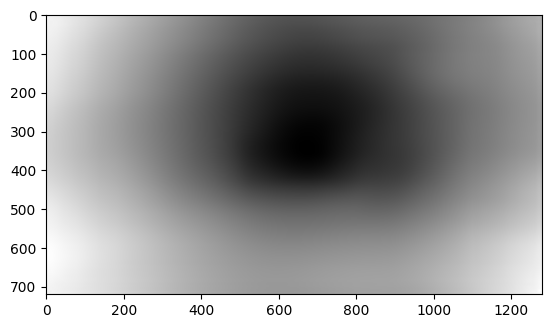

In [73]:
uint8_max = np.iinfo(np.uint8).max
normalized = cv2.normalize(depth, None, 0, uint8_max, cv2.NORM_MINMAX).astype(np.uint8)
converted = cv2.cvtColor(normalized, cv2.COLOR_GRAY2BGR)
plt.imshow(converted)

In [74]:
is_save_video = False
if is_save_video:
  cap = cv.VideoCapture(VIDEO_PATH)
  fps = cap.get(cv.CAP_PROP_FPS)
  w = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
  h = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
  display("{}x{} @ {} FPS".format(w, h, fps))
  writer = cv.VideoWriter(OUTPUT_PATH, cv.VideoWriter_fourcc(*'MJPG'), fps, (w, h))
  while cap.isOpened():
    ret, frame = cap.read()
    frame_now = cap.get(cv.CAP_PROP_POS_FRAMES)
    # if frame_now > 30:
    #   break
    if ret == False:
      break
    if frame.ndim == 2:
        frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.normalize(frame, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)
    img = frame
    img_size = img.shape[1::-1]
    resized = transform({"image": img/255})["image"]
    with torch.no_grad():
      depth = process(device, model, model_type, resized, (net_w, net_h), img_size, optimize, False)
      uint8_max = np.iinfo(np.uint8).max
      u8_mask = cv2.normalize(depth, None, 0, uint8_max, cv2.NORM_MINMAX, cv2.CV_8U)
      inverted = cv2.bitwise_not(u8_mask)
      ret, limited = cv2.threshold(inverted, 150, 255, cv.THRESH_BINARY)
      f32_mask = cv2.normalize(limited, None, 0.0, 1.0, cv2.NORM_MINMAX, cv2.CV_32F)
      f32_mask_3chan = np.repeat(f32_mask[:, :, np.newaxis], 3, axis=2)
      img_f32 = img.astype(np.float32)
      masked = cv2.multiply(img_f32, f32_mask_3chan)
      img_bgr = cv2.cvtColor(masked, cv2.COLOR_RGB2BGR)
      img_u8 = cv2.normalize(img_bgr, None, 0, uint8_max, cv2.NORM_MINMAX, cv2.CV_8U).astype(np.uint8)
      writer.write(img_u8)
  writer.release()